#PyAstrOFit: the sampler module

To constrain the planet orbits, we've adopted a robust statistical approach using the Markok chain Monte Carlo (MCMC) Bayesian analysis technique (see e.g. Ford 2005, Ford 2006, Goodman & Wear 2010). The MCMC part of PyAstrOFit makes direct use of the emcee package (Foreman-Mackey et al. 2013).

We present here different methods related to the -sampler- module, part of the PyAstrOFit package. Futhermore, this notebook shows you how to use it with several examples.

**Tips**
+ To obtain the complete docstring for a specific function, open a new cell and run: function_name?.
+ To take a look at the source code of a specific function, open a new cell and run: function_name??.

##User guide

1. [Basic Usage](#basic_usage)
2. [Quickstart](#quickstart)
  1. [Import](#import)
  2. [Before starting the Markov chain construction](#before_starting)
    + [Parameters related to the planet and its host star](#planet_star)
    + [Parameters related to the emcee Affine invariant sampler](#sampler_parameters)
  3. [Our first MCMC run](#first_run)   
    + [Instantiation](#instantiation)
    + [Let's go !](#lets_go)
    + [Visualizing the results](#wlak_corner)
    + [Saving the results](#saving)
    + [Summary](#summary)
3. [A more in depth use](#more_indepth)
    + [Initialization](#initialization)
    + [Let's go for a test !](#lets_go_test)
4. [Performing a real run](#real_run)
    + [More things to discuss](#more_things)
    + [Improving the convergence](#convergence)
    + [Let's go for a real run !](#lets_go_real_run)
5. [The AISamplerResults object](#aisamplerresults)  



## Import

Whatever part of the notebook you plan to execute, you better first run this cell.

In [1]:
import PyAstrOFit.Sampler as s
import numpy as np

%matplotlib inline 
%load_ext autoreload
%autoreload 2

________                      _                                  ____    ________
`MMMMMMMb.                   dM.                                6MMMMb   `MMMMMMM 68b
 MM    `Mb                  ,MMb                /              8P    Y8   MM    \ Y89   /
 MM     MM ____    ___      d'YM.      ____    /M     ___  __ 6M      Mb  MM      ___  /M
 MM     MM `MM(    )M'     ,P `Mb     6MMMMb\ /MMMMM  `MM 6MM MM      MM  MM   ,  `MM /MMMMM
 MM    .M9  `Mb    d'      d'  YM.   MM'    `  MM      MM69   MM      MM  MMMMMM   MM  MM
 MMMMMMM9'   YM.  ,P      ,P   `Mb   YM.       MM      MM'    MM      MM  MM   `   MM  MM
 MM           MM  M       d'    YM.   YMMMMb   MM      MM     MM      MM  MM       MM  MM
 MM           `Mbd'      ,MMMMMMMMb       `Mb  MM      MM     YM      M9  MM       MM  MM
 MM            YMP       d'      YM. L    ,MM  YM.  ,  MM      8b    d8   MM       MM  YM.  ,
_MM_            M      _dM_     _dMM_MYMMMM9    YMMM9 _MM_      YMMMM9   _MM_     _MM_  YMMM9
           

## Basic Usage <a id='basic_usage'></a> 

If you want to quickly have a general idea of the $\beta$ Pic b orbit parameters, you would do something like (< 1min):


################################################################
The MCMC run has started.

Start time: 18:00:06
################################################################
The construction of 200 walkers has started ...

--> 100 steps per walker
   Median acceptance rate (AR) 0.49504950495
   Gelman-Rubin hat_R = [ 1.068  1.033  1.005  1.002  1.026  1.046]

--> 150 steps per walker
   Median acceptance rate (AR) 0.476821192053
   Gelman-Rubin hat_R = [ 1.102  1.074  1.002  1.003  1.05   1.082]

--> 225 steps per walker
   Median acceptance rate (AR) 0.46017699115
   Gelman-Rubin hat_R = [ 1.149  1.066  1.001  0.999  1.165  1.195]

We have reached the maximum number of steps per walker (300).

################################################################
The MCMC run has finished.

End time: 18:00:35
Total duration: 0:00:29.190095
################################################################


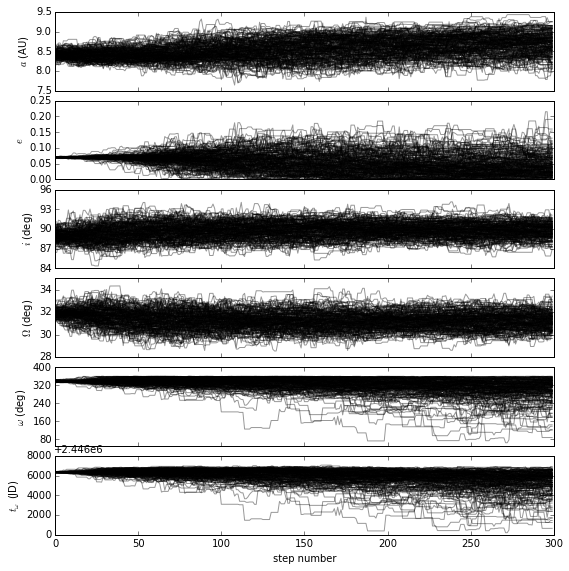

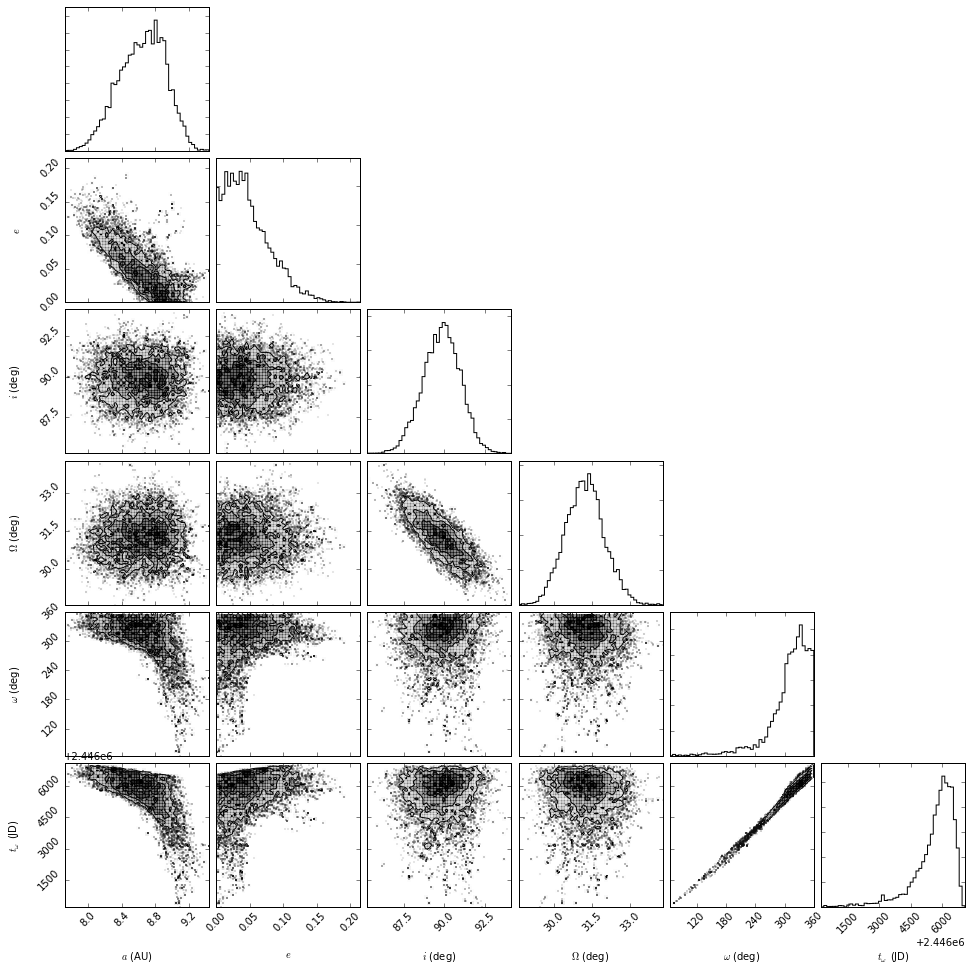

In [2]:
sampler = s.AISampler(data='betapicb', priors={'starMass' : 1.74,'starDistance' : 19.3})

mcmc_results = sampler.run_mcmc(nwalkers = 200,limit = 300)

mcmc_results.showWalk()
mcmc_results.showPDFCorner()

Of course, the result is not satisfactory for a "real" orbital fitting. But it constitutes a first insight into the operation of this module. A more complete example is available in the [Quickstart](#quickstart) section.

## Quickstart <a id='quickstart'></a> 

The easiest way to get started with using PyAstrOFit.Sampler is to use it. With this in mind, here is an annotated example that demonstrates a basic use of the package.
A more complete documentation is presented in section [A more in depth use](#more_indepth)  

###Import <a id='import'></a> 

For those who have forgotten to run the very first cell :-)

In [3]:
import PyAstrOFit.Sampler as s
import numpy as np

#To show up inline matplotlib graphics
%matplotlib inline 

###Before starting the Markov chain construction <a id='before_starting'></a> 

Before starting the MCMC run, we need to define few parameters. There are two types of parameters:

+ Those related to the planet and its host star
+ Those related to the sampler

#### Parameters related to the planet and its host star <a id='planet_star'></a> 

Here, we define some priors related to the planet and its host star, that is to say:
+ the star-planet mass $M$ in solar masses $M_\odot$
+ its distance $d$ from the Earth in parsec
+ an orbital parameter first guess $\vec{p}_0 = [a, e, i, \Omega, \omega, t_\omega]$ (dimension = [A.U.,None,deg,deg,JD])
+ any knowledge on the parameter bounds

The first guess $\vec{p}_0$ shoud be a priori preferred set of parameters, even if the rest of the parameter space will be explored. In the absence of any specific knowledge, you may set the *prior_model* to *None*. This also applies to *bounds*. In all cases, the keys *starMass* and *starDistance* are mandatory. 

In [4]:
p0 = np.array([8.42,0.07,89.04,31.87,338.25,2452353.32])
bounds = np.array([[3,20],[0,0.5],[80,110],[0,360],[0,360],[p0[5]-365*200,p0[5]+365*200]]) 

priors = {'starMass' : 1.75, 
          'starDistance' : 19.3,
          'prior_model' : p0,
          'bounds' : bounds}  

We also need a file which contains all the planet positions (and the corresponding 1-$\sigma$ confidence intervals) at given observation dates. The package already contains these files for the planets $\beta$ Pic b and HR8799bcde. Of course, you can use your own data file. Let's try with $\beta$ Pic b.

In [5]:
data = 'betapicb' # By giving 'betapicb', the data for betapicb will be automatically loaded.
                  # The txt file can be located in the folder "PyAstrOFit/res/exo/betapicb.txt".
                  # To load its own data file, just give the relative path, for instance
                  # data = 'myData/krypton.txt'

####Parameters related to the emcee Affine invariant sampler <a id='sampler_parameters'></a> 

Here, we define the basic parameters required to start a MCMC run, that is to say:
+ The number of walkers
+ The maximum number of steps per walker (to prevent too long run or to make some test)

For our example, we will run with 200 walkers and stop after 300 steps per walker. 

In [6]:
nwalkers, limit = (200, 300)

### Our first MCMC run <a id='first_run'></a> 

#####Instantiation <a id='instantiation'></a> 

 Now, we instanciate an Affine invariant Ensemble sampler object. At the moment, the MCMC work is done on the parameter $[a, e, i, \Omega, \omega, t_\omega]$.

In [7]:
sampler = s.AISampler(data, priors)

#####Let's go ! <a id='lets_go'></a> 

We will start our first MCMC run by calling the 'run_mcmc' method. It should take around 30 seconds. When verbose = True, progress messages are displayed in the shell. We will not comment that part now. Let's just start the MCMC.

In [10]:
mcmc_results = sampler.run_mcmc(nwalkers = nwalkers, limit = limit, verbose = True)


################################################################
The MCMC run has started.

Start time: 18:01:29
################################################################
The construction of 200 walkers has started ...

--> 100 steps per walker
   Median acceptance rate (AR) 0.50495049505
   >> AR is out of the limit. The hyperparameter a (2.0) should be adjusted.
   Gelman-Rubin hat_R = [ 1.123  1.117  0.999  1.     1.088  1.14 ]

--> 150 steps per walker
   Median acceptance rate (AR) 0.483443708609
   Gelman-Rubin hat_R = [ 1.225  1.129  1.006  1.004  1.153  1.205]

--> 225 steps per walker
   Median acceptance rate (AR) 0.455752212389
   Gelman-Rubin hat_R = [ 1.048  1.003  1.     0.999  1.129  1.13 ]

We have reached the maximum number of steps per walker (300).

################################################################
The MCMC run has finished.

End time: 18:01:58
Total duration: 0:00:29.220395
################################################################


The method 'run_mcmc' returns an object instance which contains all the results and the input parameters. Then, you can run as many run_mcmc method as you want and keep the results separate. For example:

mcmc_results_200 = sampler.run_mcmc(nwalkers = 200,
                                    limit = limit,
                                    verbose = True)
                                    
mcmc_results_500 = sampler.run_mcmc(nwalkers = 500,
                                    limit = limit,
                                    verbose = True)                                    

During the run, we can follow the progress of the Markov chain construction by displaying the so-called "walk plot". You just have to pass the parameter showWalk = True.
If desired, the figure can be save with PDF format (in that case, the figure will not be displayed).

#####Visualizing the results <a id='walk_corner'></a> 

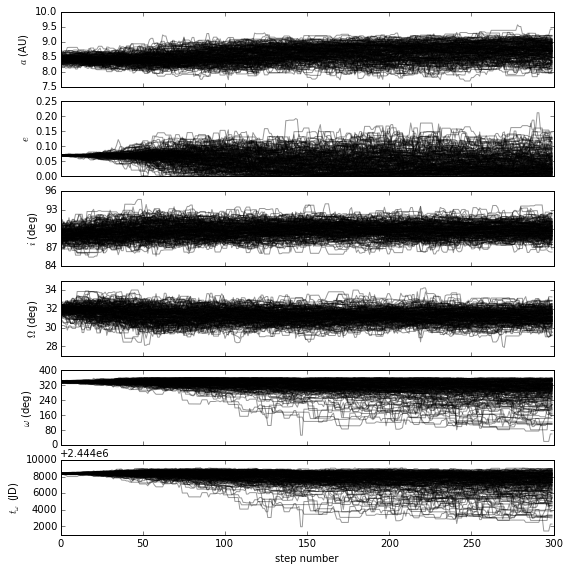

In [11]:
mcmc_results.showWalk(save = False)

We can also display the so-called "corner plot" which shows (when the convergence is reached) the marginalized probability distributions and the correponding correlation between various parameters. In our case, the convergence isn't reached. Therefore, the corner plot only represents histograms which show the current frequency of occurences. 

If desired, the figure can be save with PDF format (in that case, the figure will not be displayed).

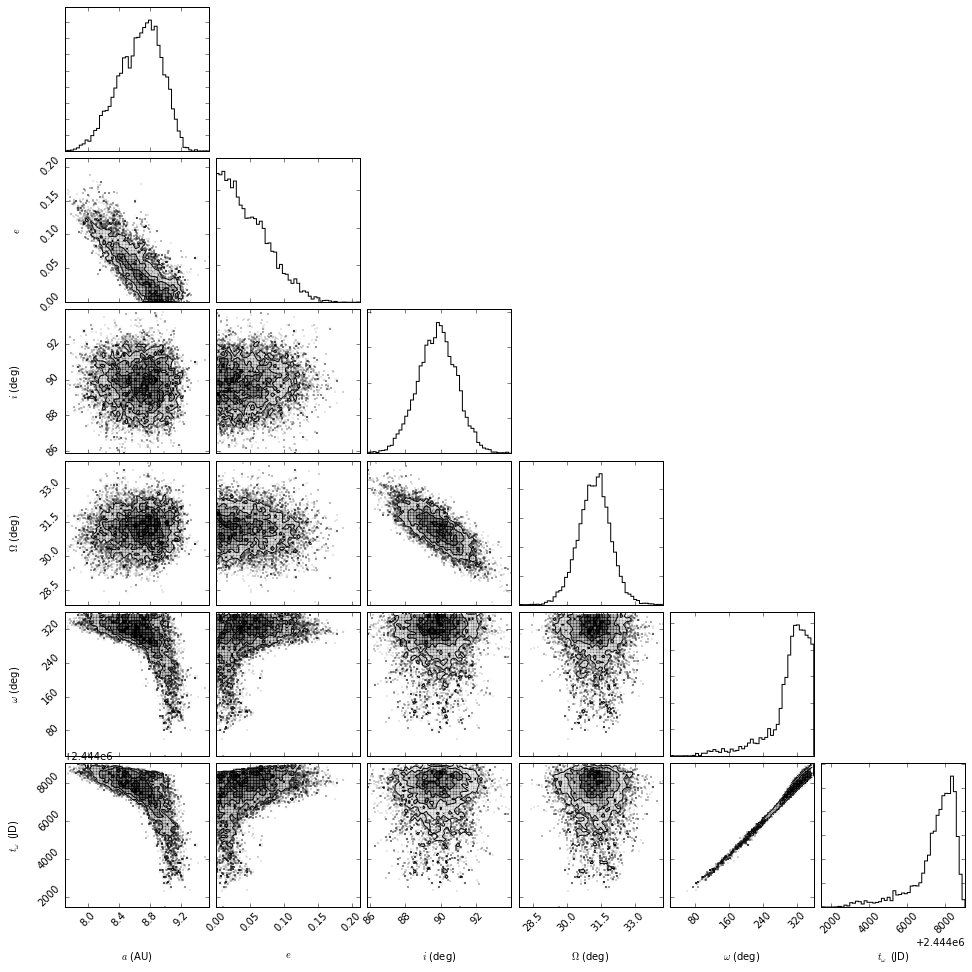

In [12]:
mcmc_results.showPDFCorner(save = False)

#####Saving the results <a id='saving'></a> 

For future use, the Markov chain can be saved either in a txt file or by "pickling".

In [ ]:
mcmc_results.save_pickle(output='betaPicb_MarkovChain')

#####Summary <a id='summary'></a> 

We present a summary of our quickstart example. Here, we display the walk plot at each step. 


################################################################
The MCMC run has started.

Start time: 18:02:04
################################################################
The construction of 200 walkers has started ...

--> 100 steps per walker
   Median acceptance rate (AR) 0.50495049505
   >> AR is out of the limit. The hyperparameter a (2.0) should be adjusted.


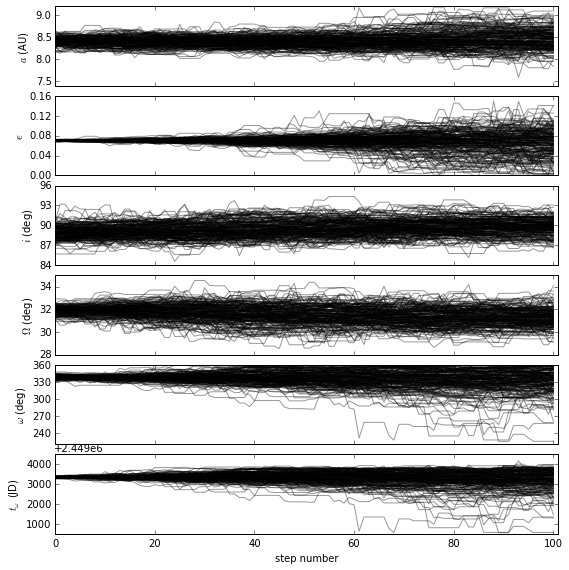

   Gelman-Rubin hat_R = [ 1.07   1.05   1.015  1.023  1.04   1.066]

--> 150 steps per walker
   Median acceptance rate (AR) 0.483443708609


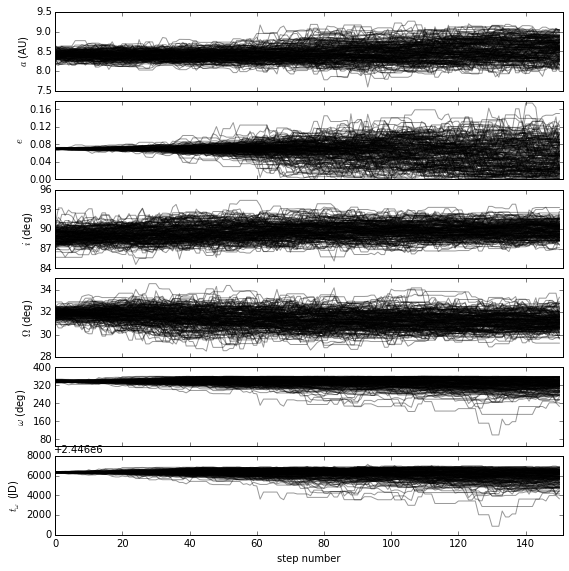

   Gelman-Rubin hat_R = [ 1.149  1.11   1.002  1.002  1.081  1.117]

--> 225 steps per walker
   Median acceptance rate (AR) 0.464601769912


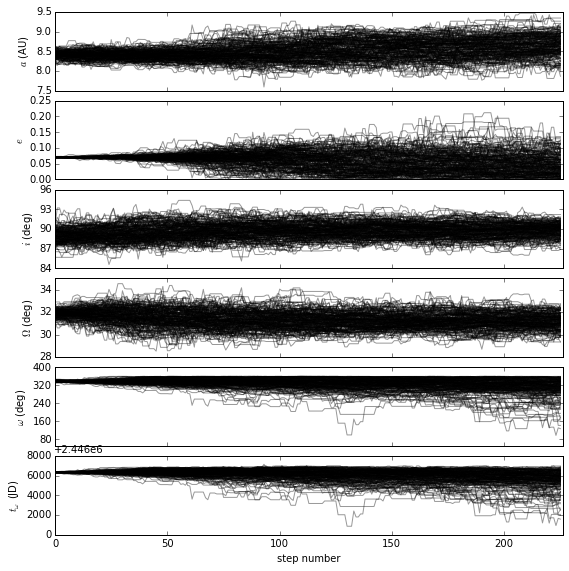

   Gelman-Rubin hat_R = [ 1.1    1.028  0.999  1.     1.123  1.138]

We have reached the maximum number of steps per walker (300).

################################################################
The MCMC run has finished.

End time: 18:02:41
Total duration: 0:00:36.471680
################################################################


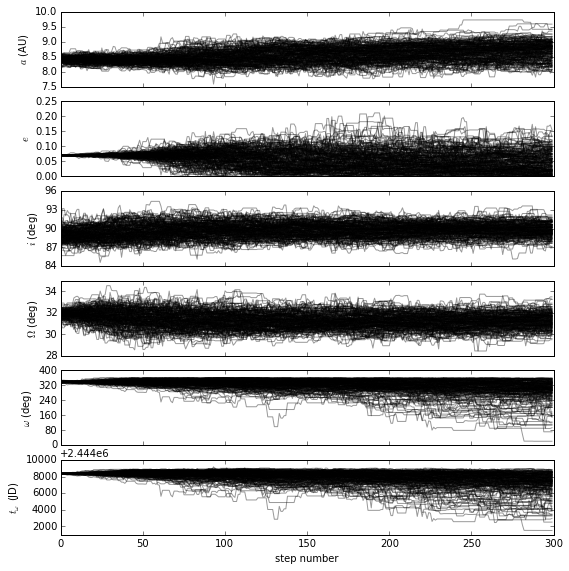

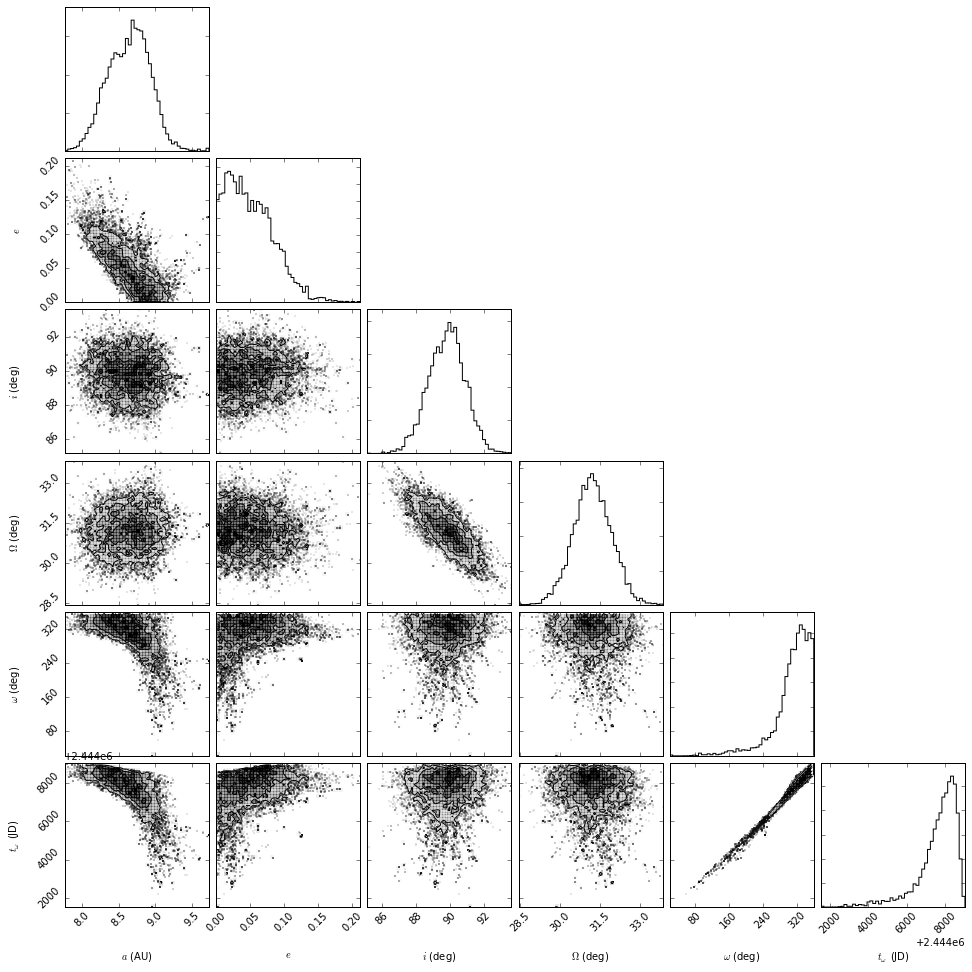

The file "betaPicb_MarkovChain" has been successfully pickled.


In [13]:
import PyAstrOFit.Sampler as s
import numpy as np

# To show up inline matplotlib graphics
%matplotlib inline 

# Priors, knowledge and data
p0 = np.array([8.42,0.07,89.04,31.87,338.25,2452353.32])
bounds = np.array([[3,20],[0,0.5],[80,110],[0,360],[0,360],[p0[5]-365*200,p0[5]+365*200]]) 

priors = {'starMass' : 1.75, 'starDistance' : 19.3, 'prior_model' : p0, 'bounds' : bounds} 
data = 'betapicb'

# AI sampler parameters
nwalkers, limit = (200, 300)
sampler = s.AISampler(data, priors)
# Let's go !
mcmc_results = sampler.run_mcmc(nwalkers = nwalkers, limit = limit, verbose = True, showWalk = True)

# Visualizing the results
mcmc_results.showWalk(save = False)
mcmc_results.showPDFCorner(save = False)

# Saving the results
mcmc_results.save_pickle(output='betaPicb_MarkovChain')

##A more in depth use <a id='more_indepth'></a>  

We will present here a more in depth use of PyAstrOFit.Sampler. Let's continue with $\beta$ Pic b.

###Initialization <a id='initialization'></a> 

We still start by importing the package and initializating few previously met parameters. Then, we instantiate an Affine invariant Ensemble sampler object.

In [14]:
import PyAstrOFit.Sampler as s
import numpy as np

#To show up inline matplotlib graphics
%matplotlib inline 

# Priors, knowledge and data
p0 = np.array([8.42,0.07,89.04,31.87,338.25,2452353.32])
bounds = np.array([[3,20],[0,0.5],[80,110],[0,360],[0,360],[p0[5]-365*200,p0[5]+365*200]]) 
priors = {'starMass' : 1.75, 'starDistance' : 19.3, 'prior_model' : p0, 'bounds' : bounds}  
data = 'betapicb'

sampler = s.AISampler(data, priors)
nwalkers = 200

We can take a look at the data before starting the mcmc. For that, we can use the method showData(): 

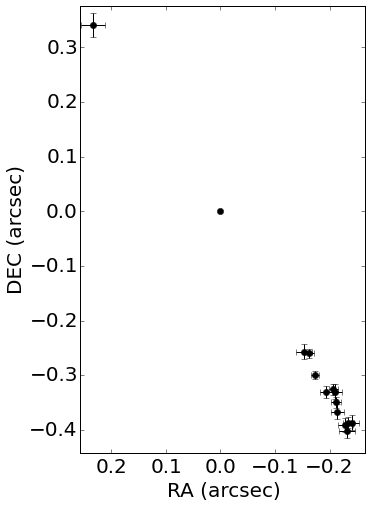

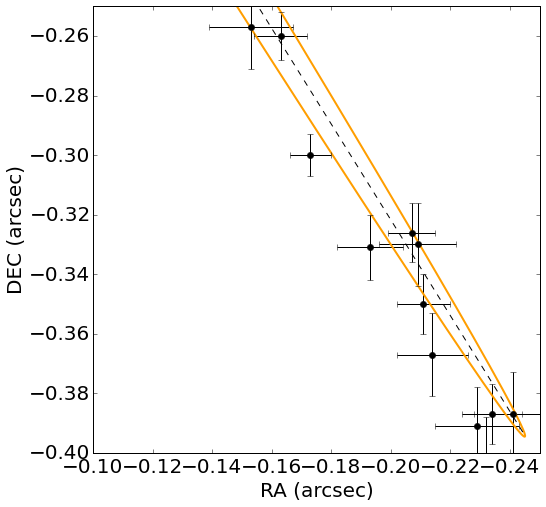

In [15]:
sampler.showData()
sampler.showData(prior_model = True, lim=[[-0.25,-0.1],[-0.4,-0.25]]) 

Before starting the MCMC run, we define new optional parameters related to the method *run_mcmc*.

 + *a*: The proposal scale parameter. The default value is 2.0. This parameter has a direct impact on the acceptance rate.
 
 
 + *threads*: The number of threads you want to use for multiprocessing. If threads is set to -1, all the available CPUs will be automatically used for the run.

 
 + *burnin*: The fraction of walkers which is automatically discarded during the non-convergence statistical test. Default: 0.5.


 + *itermin*: Steps per walker lower bound. The simulation will run at least this number of steps per walker before starting any non-convergence statistical test. Let us note that *limit* must be greater than *itermin*.
 
 
 + *supp*: Number of extra steps per walker you want to run after having reached the convergence. Default: 0.
 
 
 + *maxgap*: Maximum number of steps per walker between two non-convergence statistical test.
 
 
 + *fraction*: The number $N_j$ of steps per walker when the $j$-th non-convergence statistical test is performed automatically increases with the Markov chain. The number of steps $N_{j+1}$ per walker when the next ($j+1$-th) non-convergence test is performed is defined as follow: $N_{j+1} = N_{j} \times (1 + $ *fraction*$)$. For example, for the case of the size of a walker equals $1000$ when the $j$-th non-convergence statistical test is performed and  *fraction* is set to $0.5$, the next tests will be performed when the walker will contain respectively $N_{j+1}=1500$ steps, $N_{j+2}=2250$ steps, $N_{j+3}=3375$ steps, and so on until $N \geq$ *maxgap*. Then, $N$ is set to *maxgap*. More generally, we have $N_{j+k} = N_j \times (1 + $ *fraction*$)^k$ if $N_{j+k} <$ *maxgap*, otherwise $N_{j+k} =$ *maxgap*. 

###Let's go for a test !<a id='lets_go_test'></a> 

We are ready to start the MCMC run. Let us note that we have increased the *limit* up to 2000. When using 4 CPUs, the total duration should be < 2 min. 


################################################################
The MCMC run has started.

Start time: 18:02:47
################################################################
The construction of 200 walkers has started ...

--> 100 steps per walker
   Median acceptance rate (AR) 0.485148514851


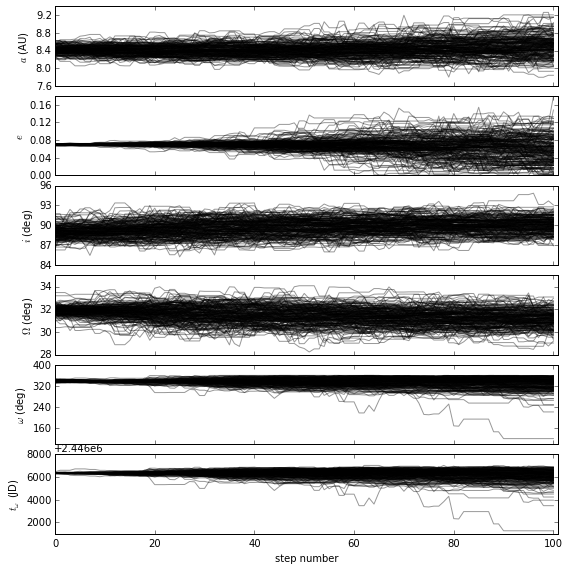

   Gelman-Rubin hat_R = [ 1.115  1.068  1.018  1.034  1.029  1.057]

--> 150 steps per walker
   Median acceptance rate (AR) 0.470198675497


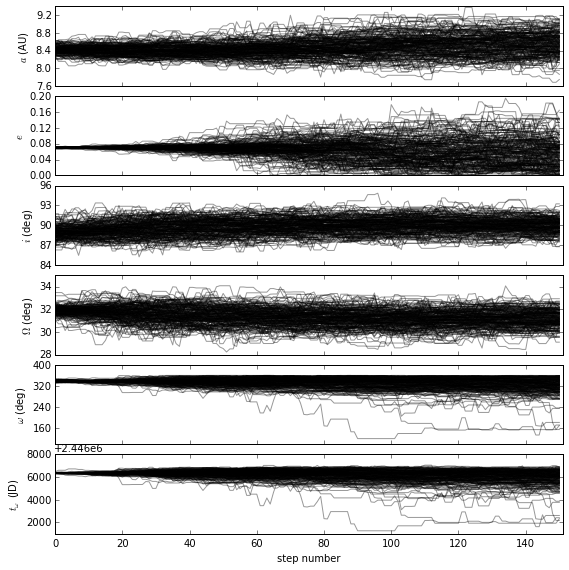

   Gelman-Rubin hat_R = [ 1.083  1.021  0.999  1.001  1.072  1.093]

--> 225 steps per walker
   Median acceptance rate (AR) 0.442477876106


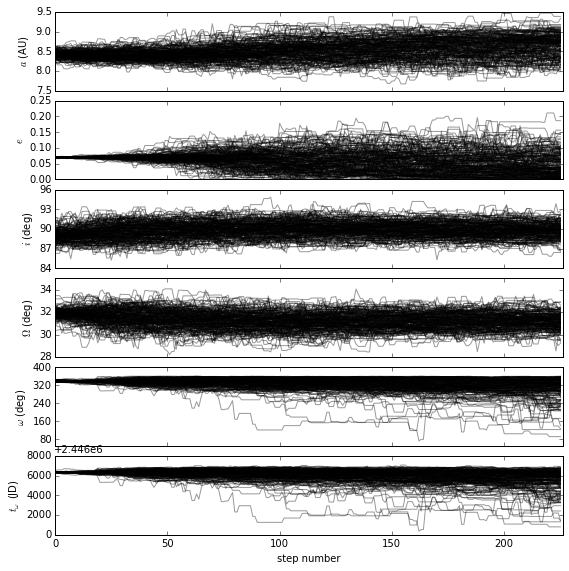

   Gelman-Rubin hat_R = [ 1.11   1.062  1.027  1.003  1.115  1.136]

--> 338 steps per walker
   Median acceptance rate (AR) 0.418879056047


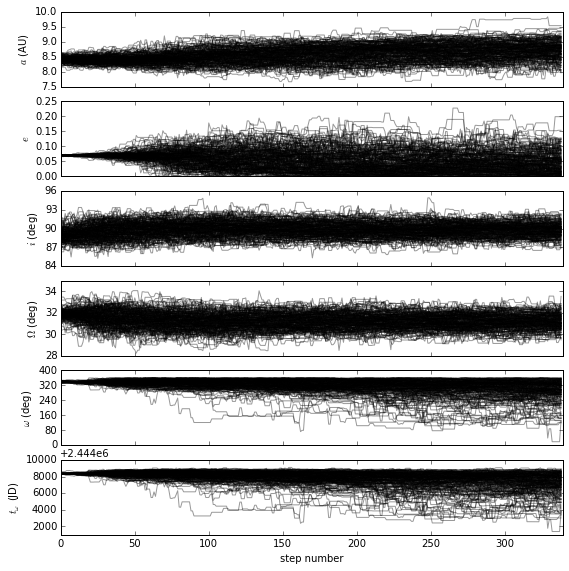

   Gelman-Rubin hat_R = [ 1.1    1.008  1.001  1.     1.169  1.177]

--> 507 steps per walker
   Median acceptance rate (AR) 0.395669291339


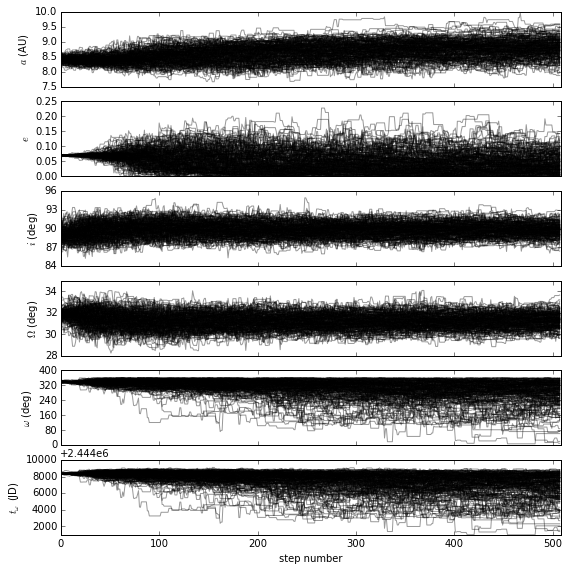

   Gelman-Rubin hat_R = [ 1.08   1.004  0.999  1.008  1.062  1.072]

We have reached the maximum number of steps per walker (600).

################################################################
The MCMC run has finished.

End time: 18:03:29
Total duration: 0:00:41.815923
################################################################


In [16]:
mcmc_results = sampler.run_mcmc(nwalkers = nwalkers,
                                a = 2.0,
                                burnin = 0.5,
                                itermin = 100,
                                limit = 600,
                                supp = 0,
                                fraction = 0.5,
                                maxgap = 1000,
                                threads = -1,
                                output = 'results/betapicb_today/',
                                verbose = True,
                                showWalk = True)

##Performing a real run <a id='real_run'></a> 

###More things to discuss <a id='more_things'></a> 

In a "real" case, there are at least three more things to do:

1. Increase the number of walkers. More is better! But, too many walkers will slow down the run. 

2. Let the run continue until the chain reaches the "convergence". The adopted non-convergence statistical test is the Gelman-Rubin $\hat{R}$ statistic (see Gelman et al. 2003). This test compares the variance of any quantity $x$ estimated from each of the individual chains (resp. chain) to the variance of the estimates of the mean $x$ from the different chains (resp. part of the chain)(Ford 2006). We have adopted the second solution, that is to say the $\hat{R}$ is calculated between two sub-chains, respectively $[\text{burnin},\text{burnin}+(1-\text{burnin})/4]$ and $[1-(1-\text{burnin})/4,1]$ parts of the main flattened chain. For example, if *burnin* is set to $0.5$, the sub-chains will be $[0.5, 0.625]$ and $[0.875, 1]$. As the Markov chain approaches convergence, $\hat{R}(p_i)$ approaches 1 from above. We can define two more parameters related to this statistical test:

    + *grThreshold*: The Gelman-Rubin threshold used for the non-convergence statistical test. A specific value can be given for any parameters (6 in total). Default: 1.01.
 
    + *grCountThreshold*: The Gelman-Rubin test must be satisfied that number of times in a row before claiming that the chain has converged. Default: 3.
    
3. Save the result in file for future analysis. To this aim, we have the method save_pickle().

###Improving the convergence <a id='convergence'></a>

Until now, the work has been done on the parameter $\vec{p} = [a, e, i, \Omega, \omega, t_\omega]$ with a uniform prior distribution. Following Ford (2006), Chauvin et al. (2012) and Pueyo et al. (2015), we can assume the prior distribution to be uniform in $\vec{u}(\vec{p}) = [\log{P}, e, \cos(i), \omega+\Omega, \omega-\Omega, t_\omega]$ and work directly on these parameters. For that, we have to change the attribut synthetic to True.

###Let's go for a real run ! <a id='lets_go_real_run'></a>

Finally, if you want to constrain the β Pic b orbit parameters, you would do something like (nwalkers = 2000, limit = 40000 ==> ~40min). Currently, nwalkers=200, limit=500, but you can modify it, it's up to you:


################################################################
The MCMC run has started.

Start time: 18:03:29
################################################################
The construction of 200 walkers has started ...

--> 100 steps per walker
   Median acceptance rate (AR) 0.485148514851


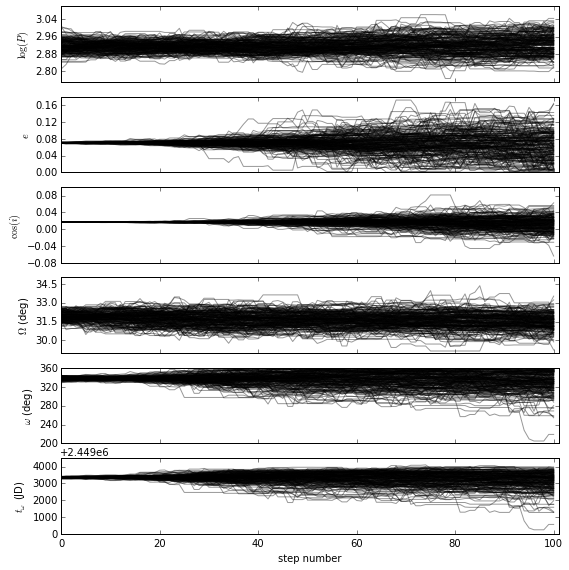

   Gelman-Rubin hat_R = [ 1.011  1.009  1.056  1.016  1.053  1.061]

--> 150 steps per walker
   Median acceptance rate (AR) 0.46357615894


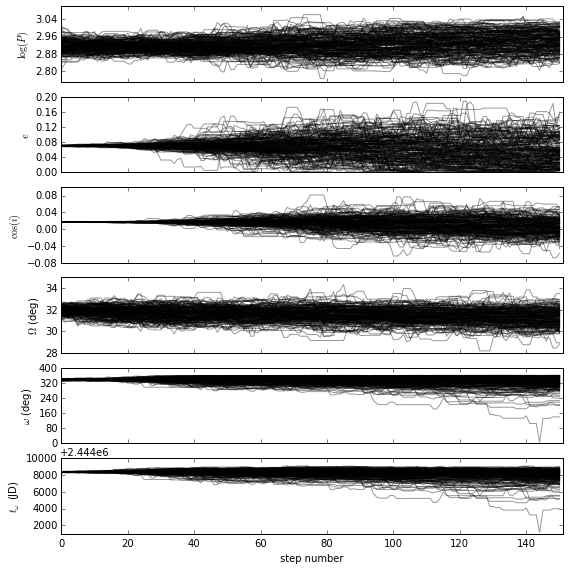

   Gelman-Rubin hat_R = [ 1.128  1.109  1.144  1.082  1.086  1.126]

--> 225 steps per walker
   Median acceptance rate (AR) 0.442477876106


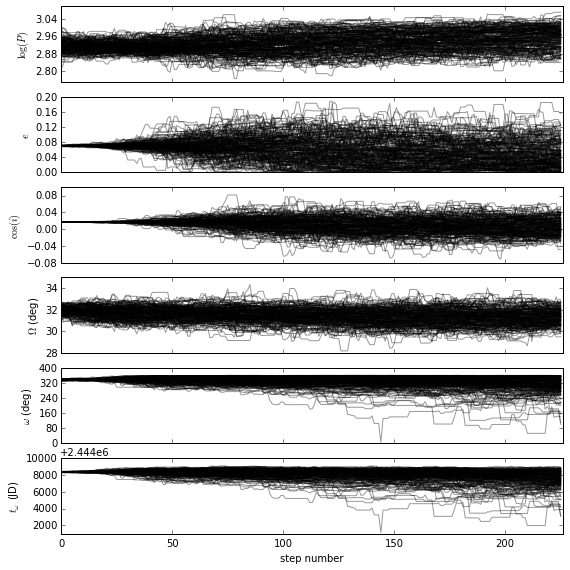

   Gelman-Rubin hat_R = [ 1.103  1.045  1.021  1.009  1.146  1.163]

--> 338 steps per walker
   Median acceptance rate (AR) 0.424778761062


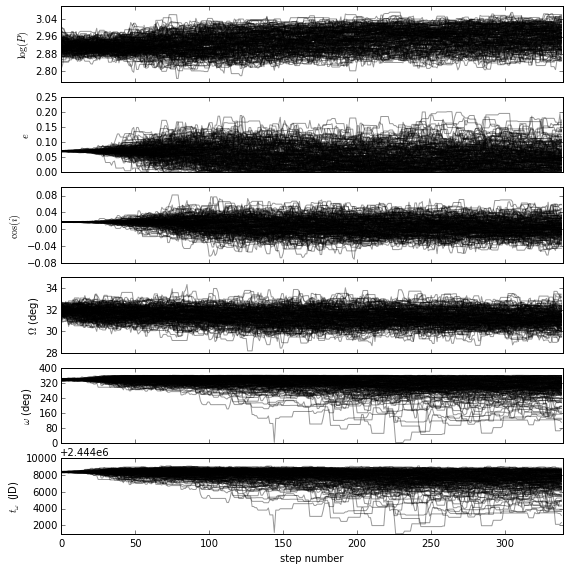

   Gelman-Rubin hat_R = [ 1.04   1.001  1.009  1.01   1.067  1.069]

We have reached the maximum number of steps per walker (500).

################################################################
The MCMC run has finished.

End time: 18:04:04
Total duration: 0:00:34.913195
################################################################


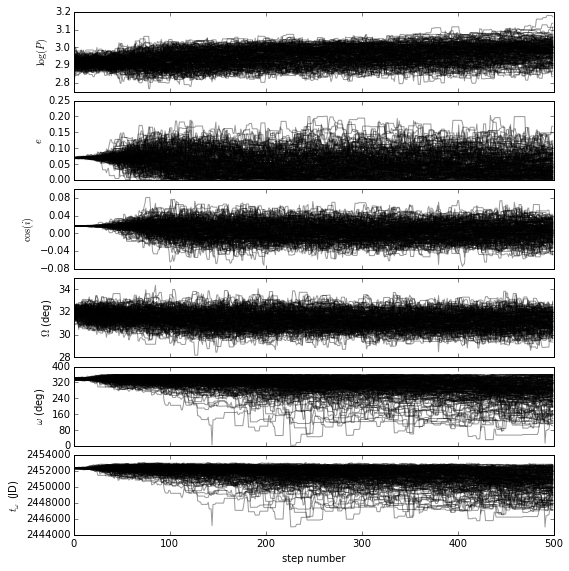

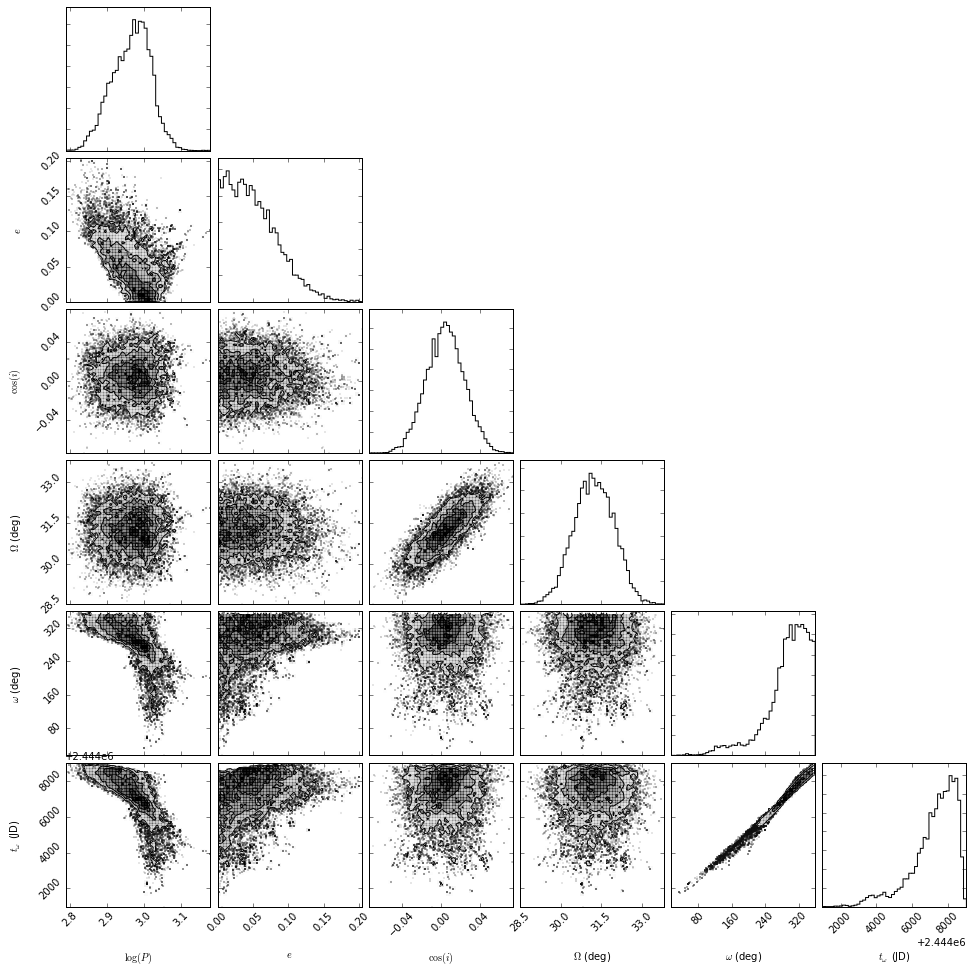

The file "results/betapicb_today/run_results" has been successfully pickled.


In [17]:
import PyAstrOFit.Sampler as s
import numpy as np

#To show up inline matplotlib graphics
%matplotlib inline 

# Priors, knowledge and data
p0 = np.array([8.42,0.07,89.04,31.87,338.25,2452353.32])
bounds = np.array([[3,20],[0,0.5],[80,110],[0,360],[0,360],[p0[5]-365*200,p0[5]+365*200]]) 
priors = {'starMass' : 1.75,'starDistance' : 19.3,'prior_model' : p0,'bounds' : bounds}  
data = 'betapicb'

sampler = s.AISampler(data, priors)

# Parameters
nwalkers, itermin, limit = (200, 100, 500)
output = 'results/betapicb_today/'            

# Let's go!
mcmc_results = sampler.run_mcmc(nwalkers = nwalkers,
                                 a = 2.0,
                                 burnin = 0.5,
                                 itermin = itermin,
                                 limit = limit,
                                 supp = 0,
                                 fraction = 0.5,
                                 maxgap = 1000,
                                 grThreshold = np.array([1.01,1.01,1.01,1.01,1.01,1.01]),
                                 grCountThreshold = 3,
                                 synthetic = True,
                                 threads = -1,
                                 output = output,
                                 verbose = True,
                                 showWalk = True)
# Display and save
mcmc_results.showWalk()
mcmc_results.showPDFCorner()
mcmc_results.save_pickle()

##The AISamplerResults object <a id='aisamplerresults'></a>

All the results returned and parameters used by the run_mcmc() method are containted in the mcmc_results. 

In [18]:
print 'The chain shape is {}.'.format(mcmc_results.chain.shape)
print 'This corresponds to {} walkers of {} steps for {} parameters.'.format(mcmc_results.chain.shape[0],mcmc_results.chain.shape[1],mcmc_results.chain.shape[2])

print ''
print 'All the input_parameters:'
print mcmc_results.input_parameters

print ''
print 'All the sampler_parameters:'
print mcmc_results.sampler_parameters

print ''
print 'All the sampler_parameters:'
print mcmc_results.internal_parameters

The chain shape is (200, 500, 6).
This corresponds to 200 walkers of 500 steps for 6 parameters.

All the input_parameters:
{'a': 2.0, 'pos_coeff': array([  1.00000000e-02,   1.00000000e-02,   1.00000000e-02,
         1.00000000e-02,   1.00000000e-02,   1.00000000e-05]), 'grThreshold': array([ 1.01,  1.01,  1.01,  1.01,  1.01,  1.01]), 'burnin': 0.5, 'verbose': True, 'synthetic': True, 'supp': 0, 'threads': 8, 'temporary': False, 'maxgap': 1000, 'limit': 500, 'fraction': 0.5, 'output': 'results/betapicb_today/', 'showWalk': True, 'itermin': 100, 'nwalkers': 200, 'grCountThreshold': 3, 'showCorner': False}

All the sampler_parameters:
{'ndim': 6, 'pKey': ['semiMajorAxis', 'eccentricity', 'inclinaison', 'longitudeAscendingNode', 'periastron', 'periastronTime'], 'theta0': array([  2.91667139e+00,   7.00000000e-02,   1.67543769e-02,
         3.18700000e+01,   3.38250000e+02,   2.45235332e+06]), 'priors': {'prior_model': array([  8.42000000e+00,   7.00000000e-02,   8.90400000e+01,
         